In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "/content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train.zip" -d "/content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/133.png  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/134.jpg  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/134.png  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/135.jpg  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/135.png  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/136.jpg  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out/136.png  
  inflating: /content/drive/MyDrive/CS231A Project/datasets/archive/nyu_data/data/nyu2_train/kitchen_0048_out

In [1]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# '.py' files from the p3 folder and the "cs231a-clevr-rgbd.zip" file
# e.g. 'cs231a/pset3/p3'
FOLDERNAME = 'CS231AProject/datasets/archive/nyu_data/data'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%ls .
%cd drive/MyDrive
%cd $FOLDERNAME

Mounted at /content/drive
drive/  sample_data/
/content/drive/MyDrive
/content/drive/.shortcut-targets-by-id/19RoXS54XirJF_HKW423-ziTKGcODFoLs/CS231AProject/datasets/archive/nyu_data/data


In [ ]:
import os

directory = 'nyu2_train/kitchen_0028a_out'


In [ ]:
# Prepare data for training, only have to run this once per directory subset
# prompt: For each jpg in nyu2_train/kitchen_0003_out, rename the file by appending "_rgb" to the name. So 1.jpg becomes 1_rgb.jpg, 2.jpg becomes 2_rgb.jpg, and so on

import os


for filename in os.listdir(directory):
  if filename.endswith(".jpg"):
    img_number = filename.split("_")[0].split(".")[0]
    base, extension = os.path.splitext(filename)
    new_filename = f"{img_number}_rgb{extension}"
    old_path = os.path.join(directory, filename)
    new_path = os.path.join(directory, new_filename)
    os.rename(old_path, new_path)
    print(f"Renamed {old_path} to {new_path}")

# For each png in nyu2_train/kitchen_0003_out, rename the file by appending "_depth" to the name. So 1.png becomes 1_depth.jpg, 2.png becomes 2_depth.png, and so on

for filename in os.listdir(directory):
  if filename.endswith(".png"):
    img_number = filename.split("_")[0].split(".")[0]
    base, extension = os.path.splitext(filename)
    new_filename = f"{img_number}_depth{extension}"
    old_path = os.path.join(directory, filename)
    new_path = os.path.join(directory, new_filename)
    os.rename(old_path, new_path)
    print(f"Renamed {old_path} to {new_path}")

print("finished renaming")


Renamed nyu2_train/kitchen_0028a_out/104.jpg to nyu2_train/kitchen_0028a_out/104_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/111.jpg to nyu2_train/kitchen_0028a_out/111_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/108.jpg to nyu2_train/kitchen_0028a_out/108_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/101.jpg to nyu2_train/kitchen_0028a_out/101_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/10.jpg to nyu2_train/kitchen_0028a_out/10_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/103.jpg to nyu2_train/kitchen_0028a_out/103_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/11.jpg to nyu2_train/kitchen_0028a_out/11_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/112.jpg to nyu2_train/kitchen_0028a_out/112_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/105.jpg to nyu2_train/kitchen_0028a_out/105_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/106.jpg to nyu2_train/kitchen_0028a_out/106_rgb.jpg
Renamed nyu2_train/kitchen_0028a_out/1.jpg to nyu2_train/kitchen_0028a_out/1_rgb.jpg
Renamed nyu2_train/kitchen_00

In [ ]:
# Save depth anything prediction for all rgb images
import os
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
from io import BytesIO
import requests
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import matplotlib.pyplot as plt

# ====== Device and dtype handling ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()

# ====== Load model and processor ======
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-base-hf")

# Always load in float32, convert model to float16 *after* moving to device
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-base-hf")
model.to(device)

if use_fp16:
    model = model.half()  # 👈 this ensures ALL weights/biases are float16

for filename in os.listdir(directory):
    if "rgb" in filename.lower():
        image_path = os.path.join(directory, filename)
        try:
            # Load and preprocess image
            rgb_image = Image.open(image_path).convert("RGB")
            inputs = image_processor(images=rgb_image, return_tensors="pt")
            inputs = {k: v.to(device=device, dtype=dtype) for k, v in inputs.items()}

            # Inference
            with torch.no_grad():
                outputs = model(**inputs)

            # Post-process depth map
            post_processed = image_processor.post_process_depth_estimation(
                outputs,
                target_sizes=[(rgb_image.height, rgb_image.width)],
            )
            predicted_depth = post_processed[0]["predicted_depth"]

            # Normalize for visualization
            predicted_depth_normalized = (predicted_depth - predicted_depth.min()) / (
                predicted_depth.max() - predicted_depth.min()
            ) * 255.0
            depth_map_image = Image.fromarray(predicted_depth_normalized.cpu().numpy().astype(np.uint8))


            img_number = filename.split("_")[0]
            output_filename = img_number + "_predicted_depth.png"
            output_path = os.path.join(directory, output_filename)
            depth_map_image.save(output_path)
            print(f"Saved depth map for {filename} as {output_filename}")

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Finished processing all images.")


Saved depth map for 104_rgb.jpg as 104_predicted_depth.png
Saved depth map for 111_rgb.jpg as 111_predicted_depth.png
Saved depth map for 108_rgb.jpg as 108_predicted_depth.png
Saved depth map for 101_rgb.jpg as 101_predicted_depth.png
Saved depth map for 10_rgb.jpg as 10_predicted_depth.png
Saved depth map for 103_rgb.jpg as 103_predicted_depth.png
Saved depth map for 11_rgb.jpg as 11_predicted_depth.png
Saved depth map for 112_rgb.jpg as 112_predicted_depth.png
Saved depth map for 105_rgb.jpg as 105_predicted_depth.png
Saved depth map for 106_rgb.jpg as 106_predicted_depth.png
Saved depth map for 1_rgb.jpg as 1_predicted_depth.png
Saved depth map for 100_rgb.jpg as 100_predicted_depth.png
Saved depth map for 109_rgb.jpg as 109_predicted_depth.png
Saved depth map for 110_rgb.jpg as 110_predicted_depth.png
Saved depth map for 113_rgb.jpg as 113_predicted_depth.png
Saved depth map for 107_rgb.jpg as 107_predicted_depth.png
Saved depth map for 102_rgb.jpg as 102_predicted_depth.png
Saved

In [ ]:
# Save error map for each pair of depth images for training
from error_map import error_map_from_arrays
import os
import numpy as np
from matplotlib.image import imread

for filename in os.listdir(directory):
    if "predicted" in filename.lower():
        img_number = filename.split("_")[0]
        depth_path = os.path.join(directory, f"{img_number}_depth.png")
        predicted_depth_path = os.path.join(directory, filename)

        #normalize depth sensor image between [0, 1] for visualizing
        sensor_depth_array = np.array(imread(depth_path))
        normalized_sensor_depth_array = (sensor_depth_array - sensor_depth_array.min()) / (sensor_depth_array.max() - sensor_depth_array.min())

        #normalize and invert predicted depth image between [0, 1] for visualizing
        predicted_depth_array = np.array(imread(predicted_depth_path))
        predicted_depth_array = (predicted_depth_array - predicted_depth_array.min()) / (predicted_depth_array.max() - predicted_depth_array.min())
        predicted_depth_array = 1 - predicted_depth_array  # Invert for visualization

        filename = os.path.join(directory, f"{img_number}_error_map.npy")
        error_map = error_map_from_arrays(normalized_sensor_depth_array, predicted_depth_array)
        np.save(filename, error_map)
        print("Error map created for " + filename)

print("finished creating all error maps")



Error map created for nyu2_train/kitchen_0028a_out/104_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/111_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/108_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/101_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/10_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/103_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/11_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/112_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/105_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/106_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/1_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/100_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/109_error_map.npy
Error map created for nyu2_train/kitchen_0028a_out/110_error_map.npy
Error map created for nyu2_train/kitch

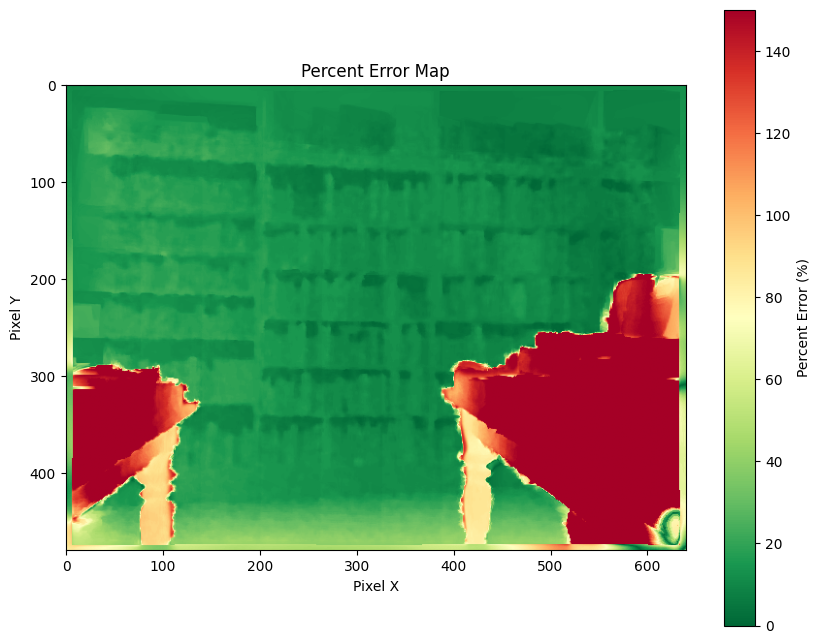

In [ ]:
#Check that error map was correct
import numpy as np
import matplotlib.pyplot as plt

percent_error = np.load("nyu2_test/test_outputs/00084_error_map.npy")
# # Create the plot

plt.figure(figsize=(10, 8))
im = plt.imshow(percent_error, cmap='RdYlGn_r')
plt.colorbar(im, label='Percent Error (%)')
plt.title('Percent Error Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.show()


In [ ]:
print(directory.split("_")[2])


0006


In [ ]:
# move all correct files to train_inputs and train_outputs with prefixed subset number
import os
import shutil

subset_number = directory.split("_")[2]
inputs_destination_folder = "nyu2_train/train_inputs"
outputs_destination_folder = "nyu2_train/train_outputs"

for filename in os.listdir(directory):
    if "error" in filename.lower():
        img_number = filename.split("_")[0]
        rgb_path = os.path.join(directory, f"{img_number}_rgb.jpg")
        predicted_depth_path = os.path.join(directory, f"{img_number}_predicted_depth.png")
        error_map_path = os.path.join(directory, f"{img_number}_error_map.npy")

        #shutil.copy2(source_file, destination_file)
        shutil.copy2(rgb_path, os.path.join(inputs_destination_folder, f"{subset_number}_{img_number}_rgb.jpg"))
        shutil.copy2(predicted_depth_path, os.path.join(inputs_destination_folder, f"{subset_number}_{img_number}_predicted_depth.png"))
        shutil.copy2(error_map_path, os.path.join(outputs_destination_folder, f"{subset_number}_{img_number}_error_map.npy"))
        count +=1

print("Current files in train:", count)



Current files in train: 2070


In [ ]:
# get test inputs and outputs set up
# Save depth anything prediction for all rgb images
import os
from transformers import pipeline
from PIL import Image
import cv2
import numpy as np
from io import BytesIO
import requests
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import matplotlib.pyplot as plt

directory = 'nyu2_test'
test_inputs_directory = 'nyu2_test/test_inputs'
test_outputs_directory = 'nyu2_test/test_outputs'

# ====== Device and dtype handling ======
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_fp16 = torch.cuda.is_available()

# ====== Load model and processor ======
image_processor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-base-hf")

# Always load in float32, convert model to float16 *after* moving to device
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-base-hf")
model.to(device)

if use_fp16:
    model = model.half()  # 👈 this ensures ALL weights/biases are float16

for filename in os.listdir(directory):
    if "colors" in filename.lower():
        image_path = os.path.join(directory, filename)
        try:
            # Load and preprocess image
            rgb_image = Image.open(image_path).convert("RGB")
            inputs = image_processor(images=rgb_image, return_tensors="pt")
            inputs = {k: v.to(device=device, dtype=dtype) for k, v in inputs.items()}

            # Inference
            with torch.no_grad():
                outputs = model(**inputs)

            # Post-process depth map
            post_processed = image_processor.post_process_depth_estimation(
                outputs,
                target_sizes=[(rgb_image.height, rgb_image.width)],
            )
            predicted_depth = post_processed[0]["predicted_depth"]

            # Normalize for visualization
            predicted_depth_normalized = (predicted_depth - predicted_depth.min()) / (
                predicted_depth.max() - predicted_depth.min()
            ) * 255.0
            depth_map_image = Image.fromarray(predicted_depth_normalized.cpu().numpy().astype(np.uint8))


            img_number = filename.split("_")[0]
            output_filename = img_number + "_predicted_depth.png"
            #save predicted depth image
            output_path = os.path.join(test_inputs_directory, output_filename)
            depth_map_image.save(output_path)
            print(f"Saved depth map for {filename} as {output_filename}")

            #make copy of rgb image
            #shutil.copy2(source_file, destination_file)
            shutil.copy2(image_path, os.path.join(test_inputs_directory, filename))

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Finished processing all images.")


In [ ]:
#save error maps
directory = "nyu2_test"
for filename in os.listdir(test_inputs_directory):
    if "predicted" in filename.lower():
        img_number = filename.split("_")[0]
        depth_path = os.path.join(directory, f"{img_number}_depth.png")
        predicted_depth_path = os.path.join(test_inputs_directory, filename)

        #normalize depth sensor image between [0, 1] for visualizing
        sensor_depth_array = np.array(imread(depth_path))
        normalized_sensor_depth_array = (sensor_depth_array - sensor_depth_array.min()) / (sensor_depth_array.max() - sensor_depth_array.min())

        #normalize and invert predicted depth image between [0, 1] for visualizing
        predicted_depth_array = np.array(imread(predicted_depth_path))
        predicted_depth_array = (predicted_depth_array - predicted_depth_array.min()) / (predicted_depth_array.max() - predicted_depth_array.min())
        predicted_depth_array = 1 - predicted_depth_array  # Invert for visualization

        filename = os.path.join(test_outputs_directory, f"{img_number}_error_map.npy")
        error_map = error_map_from_arrays(normalized_sensor_depth_array, predicted_depth_array)
        np.save(filename, error_map)
        print("Error map created for " + filename)

print("finished creating all error maps")

Error map created for nyu2_test/test_outputs/00411_error_map.npy
Error map created for nyu2_test/test_outputs/00396_error_map.npy
Error map created for nyu2_test/test_outputs/00412_error_map.npy
Error map created for nyu2_test/test_outputs/00432_error_map.npy
Error map created for nyu2_test/test_outputs/00434_error_map.npy
Error map created for nyu2_test/test_outputs/00441_error_map.npy
Error map created for nyu2_test/test_outputs/00433_error_map.npy
Error map created for nyu2_test/test_outputs/00440_error_map.npy
Error map created for nyu2_test/test_outputs/00430_error_map.npy
Error map created for nyu2_test/test_outputs/00431_error_map.npy
Error map created for nyu2_test/test_outputs/00461_error_map.npy
Error map created for nyu2_test/test_outputs/00446_error_map.npy
Error map created for nyu2_test/test_outputs/00463_error_map.npy
Error map created for nyu2_test/test_outputs/00444_error_map.npy
Error map created for nyu2_test/test_outputs/00447_error_map.npy
Error map created for nyu

In [ ]:
# prompt: For every .npy file in nyu2_train/train_outputs any nyu2_test/test_outputs clip the data to be between 0 and 150, so values less than 0 get replaced with 0 and values greater than 150 get replaced with 150. Save the file at the same name.

import numpy as np
train_outputs_directory = "nyu2_test/test_outputs"

for filename in os.listdir(train_outputs_directory):
  if filename.endswith(".npy"):
    file_path = os.path.join(train_outputs_directory, filename)
    try:
      # Load the numpy array
      data = np.load(file_path)

      # Clip the data
      clipped_data = np.clip(data, 0, 150)

      # Save the clipped data back to the same file
      np.save(file_path, clipped_data)
      print(f"Clipped and saved {filename}")

    except Exception as e:
      print(f"Error processing {filename}: {e}")

print("Finished clipping all .npy files in train_outputs.")


Clipped and saved 01126_error_map.npy
Clipped and saved 01107_error_map.npy
Clipped and saved 01108_error_map.npy
Clipped and saved 01106_error_map.npy
Clipped and saved 01122_error_map.npy
Clipped and saved 01118_error_map.npy
Clipped and saved 01124_error_map.npy
Clipped and saved 01125_error_map.npy
Clipped and saved 01127_error_map.npy
Clipped and saved 01134_error_map.npy
Clipped and saved 01135_error_map.npy
Clipped and saved 01144_error_map.npy
Clipped and saved 01130_error_map.npy
Clipped and saved 01145_error_map.npy
Clipped and saved 01147_error_map.npy
Clipped and saved 01143_error_map.npy
Clipped and saved 01129_error_map.npy
Clipped and saved 01128_error_map.npy
Clipped and saved 01146_error_map.npy
Clipped and saved 01155_error_map.npy
Clipped and saved 01152_error_map.npy
Clipped and saved 01162_error_map.npy
Clipped and saved 01149_error_map.npy
Clipped and saved 01156_error_map.npy
Clipped and saved 01154_error_map.npy
Clipped and saved 01157_error_map.npy
Clipped and 

In [ ]:
# Define Data loaders

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from PIL import Image

class DepthErrorDataset(Dataset):
  def __init__(self, input_directory, output_directory):
    self.input_directory = input_directory
    self.output_directory = output_directory
    self.input_rgb_files = sorted([f for f in os.listdir(input_directory) if (f.endswith("_rgb.jpg") or f.endswith("_rgb.png"))])
    self.input_depth_files = sorted([f for f in os.listdir(input_directory) if f.endswith("_predicted_depth.png")])
    self.output_files = sorted([f for f in os.listdir(output_directory) if f.endswith("_error_map.npy")])
    assert len(self.input_rgb_files) == len(self.output_files), "Mismatch between input and output files"

  def __len__(self):
    return len(self.input_rgb_files)

  def __getitem__(self, idx):
    rgb_filename = self.input_rgb_files[idx]
    depth_filename = self.input_depth_files[idx]
    error_filename = self.output_files[idx]

    #Load input rgb image
    rgb_path = os.path.join(self.input_directory, rgb_filename)
    rgb_image = Image.open(rgb_path).convert("RGB")
    rgb_array = np.array(rgb_image).astype(np.float32) / 255.0  # normalize to [0,1]
    rgb_tensor = torch.from_numpy(rgb_array).permute(2, 0, 1)   # [3, H, W]

    # Load input depth image
    depth_path = os.path.join(self.input_directory, depth_filename)
    depth_image = Image.open(depth_path).convert("L")
    depth_array = np.array(depth_image).astype(np.float32) / 255.0  # normalize
    depth_tensor = torch.from_numpy(depth_array).unsqueeze(0)       # [1, H, W]

    # Load output error map
    output_path = os.path.join(self.output_directory, error_filename)
    output_array = np.load(output_path).astype(np.float32)


    # Convert to PyTorch tensors
    # Stack the RGB image in here
    rgbd_tensor = torch.cat((rgb_tensor, depth_tensor), dim=0)      # [4, H, W]
    error_tensor = torch.from_numpy(output_array).unsqueeze(0) # [1, H, W] expected

    #return dictionary for loading
    return {"rgbd": rgbd_tensor, "error_map": error_tensor}



In [ ]:
# prompt: from torch.utils.data import DataLoader, Dataset. Create DepthErrorDataset from directory
# directory = 'nyu2_train/kitchen_0003_out' and use that for creating DataLoaders for training and testing, with a batch size of 32 and train test split of 0.8.

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler

train_input_directory = 'nyu2_train/train_inputs'
train_output_directory = 'nyu2_train/train_outputs'
test_input_directory = 'nyu2_test/test_inputs'
test_output_directory = 'nyu2_test/test_outputs'

# Create the dataset
train_dataset = DepthErrorDataset(train_input_directory, train_output_directory)
test_dataset = DepthErrorDataset(test_input_directory, test_output_directory)

# Define the split ratio
train_dataset_size = len(train_dataset)
print("dataset_size", train_dataset_size)
train_indices = list(range(train_dataset_size))
np.random.shuffle(train_indices)

test_dataset_size = len(test_dataset)
print("dataset_size", test_dataset_size)
test_indices = list(range(test_dataset_size))
np.random.shuffle(test_indices)

# Create data samplers
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Create DataLoaders
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_sampler)

print(f"Number of training samples: {len(train_indices)}")
print(f"Number of validation samples: {len(test_indices)}")
print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(test_dataloader)}")

dataset_size 2070
dataset_size 654
Number of training samples: 2070
Number of validation samples: 654
Number of training batches: 65
Number of validation batches: 21


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Reference : https://www.geeksforgeeks.org/implement-convolutional-autoencoder-in-pytorch-with-cuda/#
import torch.nn as nn

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder: 4 convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=3, stride=1, padding=1),  # Layer 1
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1), # Layer 2
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),  # Layer 3
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),   # Layer 4
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Decoder: 4 transposed convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),  # Layer 1
            nn.ReLU(),

            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1), # Layer 2
            nn.ReLU(),

            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),# Layer 3
            nn.ReLU(),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # Layer 4
            nn.Sigmoid()  # Or ReLU, depending on your use case
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Initialize the autoencoder
model = Autoencoder()

# # Define transform
# transform = transforms.Compose([
#     transforms.Resize((64, 64)),
#     transforms.ToTensor(),
# ])


# # Move the model to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# model.to(device)

# # Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Train the autoencoder
# num_epochs = 50
# for epoch in range(num_epochs):
#     for data in train_loader:
#         img, _ = data
#         img = img.to(device)
#         optimizer.zero_grad()
#         output = model(img)
#         loss = criterion(output, img)
#         loss.backward()
#         optimizer.step()
#     if epoch % 5== 0:
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# # Save the model
# torch.save(model.state_dict(), 'conv_autoencoder.pth')

In [ ]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
])


# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 50
for epoch in range(num_epochs):
    for data in train_dataloader:
        img = data['rgbd'] # 4 channel
        target = data['error_map']
        img = img.to(device)
        target = target.to(device) # Move target tensor to the same device as img
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Save the model
torch.save(model.state_dict(), 'depth_error_prediction_normalized_4layer_autoencoder.pth')


# Test Results using Test Dataloader



cuda
Epoch [1/50], Loss: 11192.2549
Epoch [6/50], Loss: 10644.8984
Epoch [11/50], Loss: 13455.3379
Epoch [16/50], Loss: 11210.9385
Epoch [21/50], Loss: 10935.8955
Epoch [26/50], Loss: 12121.6992
Epoch [31/50], Loss: 13451.3662
Epoch [36/50], Loss: 10405.7070
Epoch [41/50], Loss: 14857.2217
Epoch [46/50], Loss: 11826.1602


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the model to float16 if using CUDA and it was trained in float16
# Move the model to GPU first
model.to(device)

use_fp16 = torch.cuda.is_available() # Assuming training was done in float16 if GPU was available
if use_fp16:
    model = model.half() # Convert model to float16 before loading weights

# Load the pre-trained weights
path_to_weights = 'depth_error_prediction_normalized_4layer_autoencoder.pth'
# Load state dict with map_location to ensure weights are on the correct device
# and potentially the correct dtype if saved in a different format
model.load_state_dict(torch.load(path_to_weights, map_location=device))

# Set the model to evaluation mode
model.eval()

# Load the image using PIL and convert to grayscale
predicted_depth_for_testing_pil = Image.open('nyu2_test/test_inputs/00196_predicted_depth.png').convert('L')
rgb_image_for_testing_pil = Image.open('nyu2_test/test_inputs/00196_rgb.png').convert('RGB')
# Convert to a NumPy array and normalize
predicted_depth_for_testing_array = np.array(predicted_depth_for_testing_pil).astype(np.float32) / 255.0
rgb_image_for_testing_array = np.array(rgb_image_for_testing_pil).astype(np.float32) / 255.0
# Convert to a PyTorch tensor and add a channel dimension
predicted_depth_for_testing_tensor = torch.from_numpy(predicted_depth_for_testing_array).unsqueeze(0)
rgb_image_for_testing_tensor = torch.from_numpy(rgb_image_for_testing_array).permute(2, 0, 1)

input_tensor = torch.cat((rgb_image_for_testing_tensor, predicted_depth_for_testing_tensor), dim=0)

print(input_tensor.shape)

# Move the input tensor to the same device as the model
input_tensor = input_tensor.to(device)

# Cast the input tensor to the same dtype as the model's parameters
# Get the dtype from one of the model's parameters (e.g., the first layer's weight)
model_dtype = next(model.parameters()).dtype
input_tensor = input_tensor.to(dtype=model_dtype)

#Try getting an error map
# Add torch.no_grad() context manager for inference
with torch.no_grad():
    error_map_result = model(input_tensor).cpu().detach().squeeze().numpy()

print("error map min: ,", error_map_result.min())
print("error map max: ,", error_map_result.max())
#normalize output
error_map_result = (error_map_result - error_map_result.min()) / (error_map_result.max() - error_map.py.min())
# # Create the plot

plt.figure(figsize=(10, 8))
im = plt.imshow(error_map_result, cmap='RdYlGn_r')
plt.colorbar(im, label='Predicted Percent Error (%)')
plt.title('Predicted Uncertainty Map')
plt.clim(0, 1)
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.show()

NameError: name 'model' is not defined

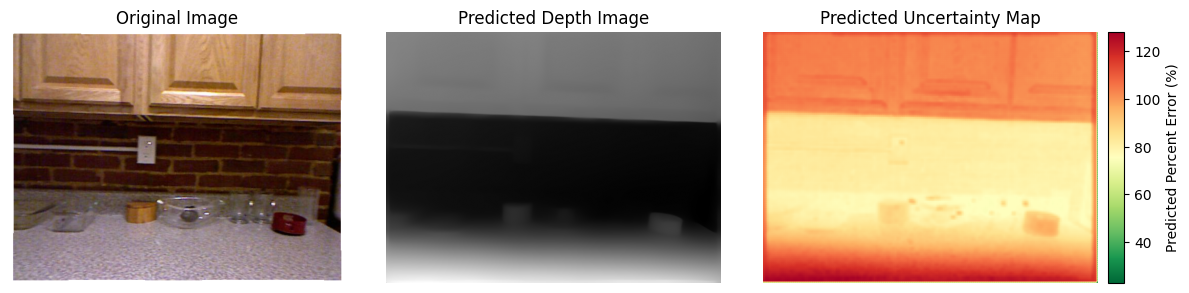

In [ ]:
# prompt: Matplotlib with 3 subfigs in a row: rgb_image_for_testing_pil, predicted_depth_for_testing_pil, error_map_result

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a plot with 3 subplots
fig, axes = plt.subplots(1, 3, tight_layout=True)
fig.set_figwidth(12)
fig.set_figheight(8)
ax = axes.ravel()

# Subplot 0
pos = ax[0].imshow(rgb_image_for_testing_pil)
ax[0].set_title('Original Image')
ax[0].axis('off')
# Create the colorbar axis on the right side of ax[0]
div0 = make_axes_locatable(ax[0])
cax0 = div0.append_axes("right", size="5%", pad=0.1)
# Turn off the axis so you can't see it
cax0.set_axis_off()

# Subplot 1
pos = ax[1].imshow(predicted_depth_for_testing_pil, cmap = 'gray')
ax[1].set_title('Predicted Depth Image')
ax[1].axis('off')
# Create the colorbar axis on the right side of ax[0]
div1 = make_axes_locatable(ax[1])
cax1 = div1.append_axes("right", size="5%", pad=0.1)
# Turn off the axis so you can't see it
cax1.set_axis_off()

# Subplot 2
pos = ax[2].imshow(error_map_result, cmap='RdYlGn_r')
ax[2].set_title('Predicted Uncertainty Map')
ax[2].axis('off')
# Create the colorbar axis on the right side of ax[0]
div2 = make_axes_locatable(ax[2])
cax2 = div2.append_axes("right", size="5%", pad=0.1)
fig.colorbar(pos, cax=cax2).set_label("Predicted Percent Error (%)")


plt.show()

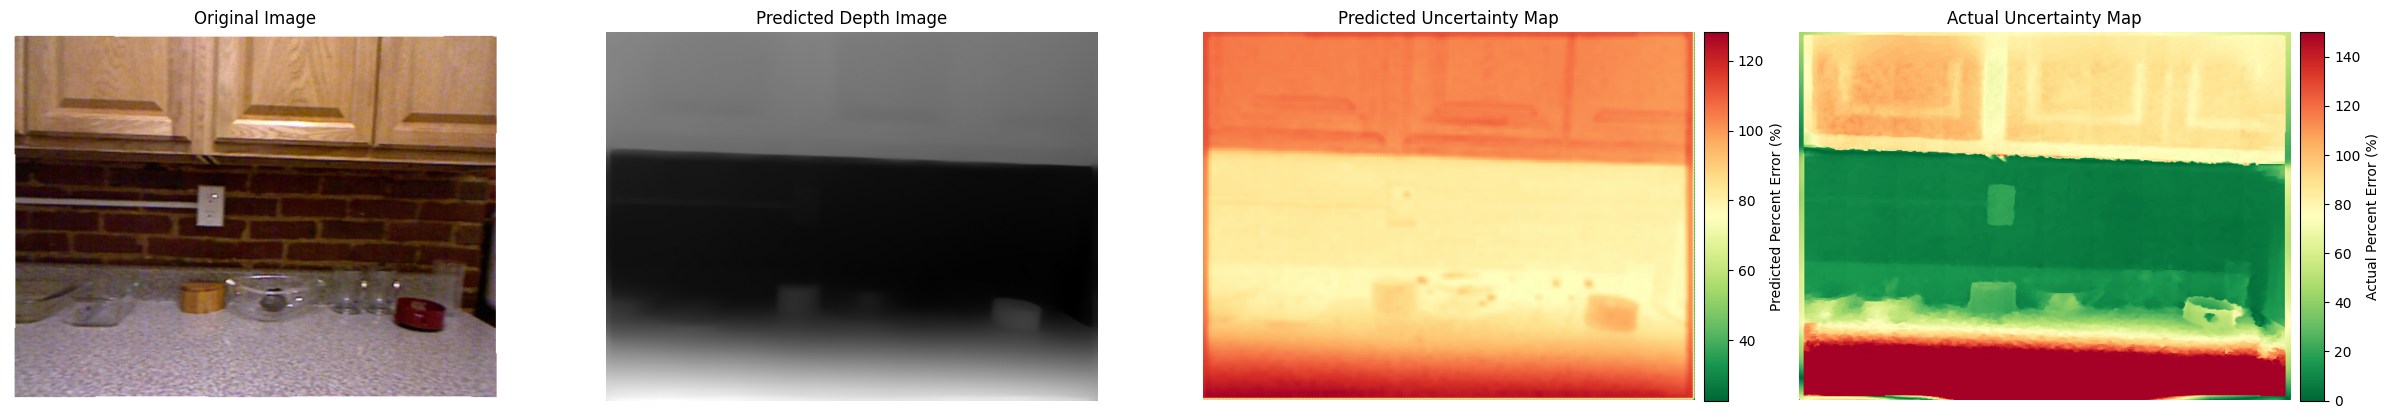

In [ ]:
# prompt: Matplotlib with 4 subfigs in a row: rgb_image_for_testing_pil, predicted_depth_for_testing_pil, error_map_result, actual error_map

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

actual_error_map = np.load('nyu2_test/test_outputs/00196_error_map.npy')

# Create a plot with 4 subplots
fig, axes = plt.subplots(1, 4, tight_layout=True)
fig.set_figwidth(24)
fig.set_figheight(8)
ax = axes.ravel()

# Subplot 0
pos = ax[0].imshow(rgb_image_for_testing_pil)
ax[0].set_title('Original Image')
ax[0].axis('off')
# Create the colorbar axis on the right side of ax[0]
div0 = make_axes_locatable(ax[0])
cax0 = div0.append_axes("right", size="5%", pad=0.1)
# Turn off the axis so you can't see it
cax0.set_axis_off()

# Subplot 1
pos = ax[1].imshow(predicted_depth_for_testing_pil, cmap = 'gray')
ax[1].set_title('Predicted Depth Image')
ax[1].axis('off')
# Create the colorbar axis on the right side of ax[0]
div1 = make_axes_locatable(ax[1])
cax1 = div1.append_axes("right", size="5%", pad=0.1)
# Turn off the axis so you can't see it
cax1.set_axis_off()

# Subplot 2
pos = ax[2].imshow(error_map_result, cmap='RdYlGn_r')
ax[2].set_title('Predicted Uncertainty Map')
ax[2].axis('off')
# Create the colorbar axis on the right side of ax[0]
div2 = make_axes_locatable(ax[2])
cax2 = div2.append_axes("right", size="5%", pad=0.1)
fig.colorbar(pos, cax=cax2).set_label("Predicted Percent Error (%)")

# Subplot 3
pos = ax[3].imshow(actual_error_map, cmap='RdYlGn_r')
ax[3].set_title('Actual Uncertainty Map')
ax[3].axis('off')
# Create the colorbar axis on the right side of ax[0]
div3 = make_axes_locatable(ax[3])
cax3 = div3.append_axes("right", size="5%", pad=0.1)
fig.colorbar(pos, cax=cax3).set_label("Actual Percent Error (%)")


plt.show()

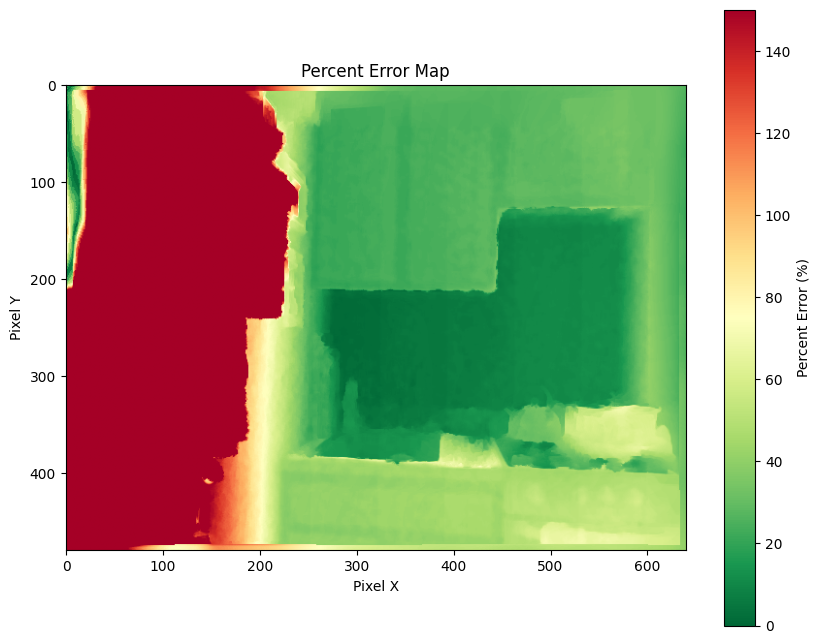

In [ ]:
#Check that error map was correct
import numpy as np
import matplotlib.pyplot as plt

percent_error = np.load("nyu2_test/test_outputs/00249_error_map.npy")
# # Create the plot

plt.figure(figsize=(10, 8))
im = plt.imshow(percent_error, cmap='RdYlGn_r')
plt.colorbar(im, label='Percent Error (%)')
plt.clim(0, 150)
plt.title('Percent Error Map')
plt.xlabel('Pixel X')
plt.ylabel('Pixel Y')

plt.show()


In [ ]:
# Define transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Move the model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_total = 0
loss_count = 0

# Train the autoencoder

for data in test_dataloader:
    img = data['rgbd'] # 4 channel
    target = data['error_map']

    # Move input and target to the correct device
    img = img.to(device)
    target = target.to(device) # Move target tensor to the same device as img

    # Get the model's data type
    model_dtype = next(model.parameters()).dtype

    # Cast the input tensor to the model's data type
    img = img.to(dtype=model_dtype)

    optimizer.zero_grad()
    output = model(img)
    loss = criterion(output, target)
    loss_total += loss.item()
    loss_count += 1
    optimizer.step()

print("Average Loss: ", loss_total/loss_count)

#report: average loss, pictures of example outputs,

cuda
Average Loss:  2520.0555361793154
